In [1]:
import ROOT
import numpy as np
from scipy.optimize import brent
from scipy.stats.distributions import poisson
import iminuit
from matplotlib import pyplot as plt
%matplotlib inline

Welcome to JupyROOT 6.20/02


# Migrating ROOT Pulse Fitting Algorithm to Python
This notebook aims to migrate the pulse fitting algorithm used in the ROOT generate_ac_tf script to Python.

## Step 1: Demonstrate existing ROOT algorithm
This is the pulse fitting algorithm as it currently is implemented in the ROOT script

In [2]:
# Load dataset
wf = np.loadtxt("test_wf.txt")
vped = 800
fHist = ROOT.TH1F("", "", wf.size, 0.0, wf.size)
for isample, sample in enumerate(wf):
    fHist.SetBinContent(isample+1, sample)
    
x_wf = np.array([fHist.GetBinCenter(ii+1) for ii in range(wf.size)])
y_wf = np.array([fHist.GetBinContent(ii+1) for ii in range(wf.size)], dtype=np.int)

In [10]:
def root_fit():
    # Create the fit function as the sum of two landau functions
    fFit = ROOT.TF1("fFit","landau+landau(3)",0,wf.size);

    # Default fit parameter settings
    PEAKPOS = 30
    if ((fFit.GetParameter(0) < 1e-6) & (vped > 0.0)):
        fFit.SetParameter(0,vped*11.0);
        fFit.SetParameter(1,PEAKPOS);
        fFit.SetParameter(2,3.0);
        fFit.SetParameter(3,vped*(-2.75));
        fFit.SetParameter(4,PEAKPOS+21);
        fFit.SetParameter(5,6.5);
    elif ((fFit.GetParameter(0) > -1e-6) & (vped < 0.0)):
        fFit.SetParameter(0,vped*4.0);
        fFit.SetParameter(1,PEAKPOS);
        fFit.SetParameter(2,3.0);
        fFit.SetParameter(3,vped*(-1.5));
        fFit.SetParameter(4,PEAKPOS+34);
        fFit.SetParameter(5,6.5);

    # Perform fit
    r = fHist.Fit("fFit","WWRQS");
    root_fit_chi2 = r.Chi2()
    return fFit, root_fit_chi2
    
fFit, root_fit_chi2 = root_fit()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: myCanvasName


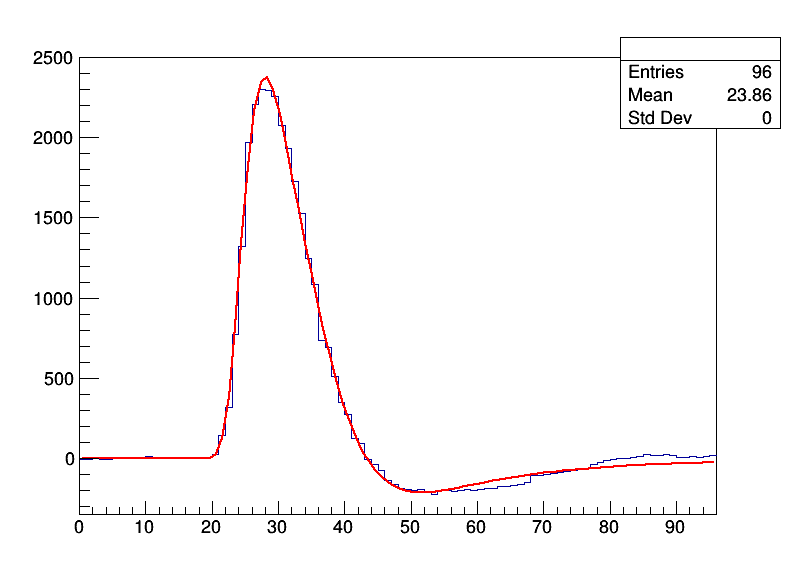

In [11]:
# Plot result
c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
fHist.Draw()
c.Draw()

## Step 2: How Does ROOT Define Landau?
From the ROOT source code at https://root.cern.ch/root/html524/src/TMath.cxx.html#512 and https://root.cern/doc/v608/PdfFuncMathCore_8cxx_source.html#l00191 we can redeclare the landau function from first principles:

In [12]:
%%cpp -d
double cpp_landau_pdf(double x, double xi=1, double x0=0) {
   // LANDAU pdf : algorithm from CERNLIB G110 denlan
   // same algorithm is used in GSL

   static double p1[5] = {0.4259894875,-0.1249762550, 0.03984243700, -0.006298287635,   0.001511162253};
   static double q1[5] = {1.0         ,-0.3388260629, 0.09594393323, -0.01608042283,    0.003778942063};

   static double p2[5] = {0.1788541609, 0.1173957403, 0.01488850518, -0.001394989411,   0.0001283617211};
   static double q2[5] = {1.0         , 0.7428795082, 0.3153932961,   0.06694219548,    0.008790609714};

   static double p3[5] = {0.1788544503, 0.09359161662,0.006325387654, 0.00006611667319,-0.000002031049101};
   static double q3[5] = {1.0         , 0.6097809921, 0.2560616665,   0.04746722384,    0.006957301675};

   static double p4[5] = {0.9874054407, 118.6723273,  849.2794360,   -743.7792444,      427.0262186};
   static double q4[5] = {1.0         , 106.8615961,  337.6496214,    2016.712389,      1597.063511};

   static double p5[5] = {1.003675074,  167.5702434,  4789.711289,    21217.86767,     -22324.94910};
   static double q5[5] = {1.0         , 156.9424537,  3745.310488,    9834.698876,      66924.28357};

   static double p6[5] = {1.000827619,  664.9143136,  62972.92665,    475554.6998,     -5743609.109};
   static double q6[5] = {1.0         , 651.4101098,  56974.73333,    165917.4725,     -2815759.939};

   static double a1[3] = {0.04166666667,-0.01996527778, 0.02709538966};

   static double a2[2] = {-1.845568670,-4.284640743};

   if (xi <= 0) return 0;
   double v = (x - x0)/xi;
   double u, ue, us, denlan;
   if (v < -5.5) {
      u   = std::exp(v+1.0);
      if (u < 1e-10) return 0.0;
      ue  = std::exp(-1/u);
      us  = std::sqrt(u);
      denlan = 0.3989422803*(ue/us)*(1+(a1[0]+(a1[1]+a1[2]*u)*u)*u);
   } else if(v < -1) {
      u   = std::exp(-v-1);
      denlan = std::exp(-u)*std::sqrt(u)*
         (p1[0]+(p1[1]+(p1[2]+(p1[3]+p1[4]*v)*v)*v)*v)/
         (q1[0]+(q1[1]+(q1[2]+(q1[3]+q1[4]*v)*v)*v)*v);
   } else if(v < 1) {
      denlan = (p2[0]+(p2[1]+(p2[2]+(p2[3]+p2[4]*v)*v)*v)*v)/
         (q2[0]+(q2[1]+(q2[2]+(q2[3]+q2[4]*v)*v)*v)*v);
   } else if(v < 5) {
      denlan = (p3[0]+(p3[1]+(p3[2]+(p3[3]+p3[4]*v)*v)*v)*v)/
         (q3[0]+(q3[1]+(q3[2]+(q3[3]+q3[4]*v)*v)*v)*v);
   } else if(v < 12) {
      u   = 1/v;
      denlan = u*u*(p4[0]+(p4[1]+(p4[2]+(p4[3]+p4[4]*u)*u)*u)*u)/
         (q4[0]+(q4[1]+(q4[2]+(q4[3]+q4[4]*u)*u)*u)*u);
   } else if(v < 50) {
      u   = 1/v;
      denlan = u*u*(p5[0]+(p5[1]+(p5[2]+(p5[3]+p5[4]*u)*u)*u)*u)/
         (q5[0]+(q5[1]+(q5[2]+(q5[3]+q5[4]*u)*u)*u)*u);
   } else if(v < 300) {
      u   = 1/v;
      denlan = u*u*(p6[0]+(p6[1]+(p6[2]+(p6[3]+p6[4]*u)*u)*u)*u)/
         (q6[0]+(q6[1]+(q6[2]+(q6[3]+q6[4]*u)*u)*u)*u);
   } else {
      u   = 1/(v-v*std::log(v)/(v+1));
      denlan = u*u*(1+(a2[0]+a2[1]*u)*u);
   }
   return denlan/xi;

}
Double_t cpp_landau(Double_t x, Double_t mpv, Double_t sigma, Bool_t norm)
{
   // The LANDAU function. 
   // mpv is a location parameter and correspond approximatly to the most probable value
   // and sigma is a scale parameter (not the sigma of the full distribution which is not defined)
   // Note that for mpv=0 and sigma=1 (default values) the exact location of the maximum of the distribution (most proble value) is at 
   // x = -0.22278
   // This function has been adapted from the CERNLIB routine G110 denlan.
   // If norm=kTRUE (default is kFALSE) the result is divided by sigma

   if (sigma <= 0) return 0; 
   Double_t den = cpp_landau_pdf( (x-mpv)/sigma ); 
   if (!norm) return den;
   return den/sigma;
}

input_line_94:66:10: error: redefinition of 'cpp_landau'
Double_t cpp_landau(Double_t x, Double_t mpv, Double_t sigma, Bool_t norm)
         ^
input_line_90:66:10: note: previous definition is here
Double_t cpp_landau(Double_t x, Double_t mpv, Double_t sigma, Bool_t norm)
         ^


In [13]:
formula = "[p0]*cpp_landau(x,[p1],[p2],false)+[p3]*cpp_landau(x,[p4],[p5],false)"
fFit_cpp = ROOT.TF1("fFit_cpp",formula,0,wf.size)
for i in range(6):
    fFit_cpp.SetParameter(i, fFit.GetParameter(i))

XMaximum =  28.05727358025616


Warning in <TCanvas::Constructor>: Deleting canvas with same name: myCanvasName


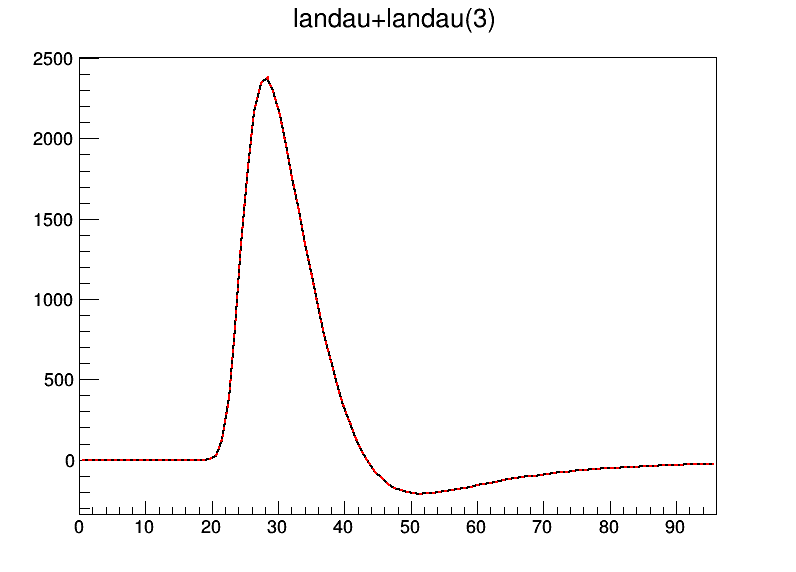

In [14]:
# Plot result
c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
fFit.SetLineColor(1)
fFit.Draw()
fFit_cpp.SetLineStyle(2)
fFit_cpp.Draw('same')
c.Draw()
for x in range(90):
    assert fFit.Eval(x) == fFit_cpp.Eval(x)
print("XMaximum = ", fFit.GetMaximumX())

In [16]:
# Store curve in numpy array for further python plotting
x_cpp = np.linspace(fFit.GetXmin(), fFit.GetXmax(), 1000)
y_cpp = np.array([fFit.Eval(xx) for xx in x_cpp])
fit_params = [fFit.GetParameter(i) for i in range(fFit.GetNumberFreeParameters())]

## Step 3: Create a Python Landau function

In [17]:
def py_landau_pdf(x, xi=1, x0=0):
    p1 = [0.4259894875,-0.1249762550, 0.03984243700, -0.006298287635,   0.001511162253]
    q1 = [1.0         ,-0.3388260629, 0.09594393323, -0.01608042283,    0.003778942063]
    
    p2 = [0.1788541609, 0.1173957403, 0.01488850518, -0.001394989411,   0.0001283617211]
    q2 = [1.0         , 0.7428795082, 0.3153932961,   0.06694219548,    0.008790609714]

    p3 = [0.1788544503, 0.09359161662,0.006325387654, 0.00006611667319,-0.000002031049101]
    q3 = [1.0         , 0.6097809921, 0.2560616665,   0.04746722384,    0.006957301675]

    p4 = [0.9874054407, 118.6723273,  849.2794360,   -743.7792444,      427.0262186]
    q4 = [1.0         , 106.8615961,  337.6496214,    2016.712389,      1597.063511]

    p5 = [1.003675074,  167.5702434,  4789.711289,    21217.86767,     -22324.94910]
    q5 = [1.0         , 156.9424537,  3745.310488,    9834.698876,      66924.28357]

    p6 = [1.000827619,  664.9143136,  62972.92665,    475554.6998,     -5743609.109]
    q6 = [1.0         , 651.4101098,  56974.73333,    165917.4725,     -2815759.939]

    a1 = [0.04166666667,-0.01996527778, 0.02709538966]

    a2 = [-1.845568670,-4.284640743]

    if (xi <= 0):
        return 0
    v = (x - x0)/xi
    if (v < -5.5):
        u   = np.exp(v+1.0)
        if (u < 1e-10): 
            return 0.0
        ue  = np.exp(-1/u)
        us  = np.sqrt(u)
        denlan = 0.3989422803*(ue/us)*(1+(a1[0]+(a1[1]+a1[2]*u)*u)*u)
    elif (v < -1):
        u   = np.exp(-v-1);
        denlan = np.exp(-u)*np.sqrt(u)*(p1[0]+(p1[1]+(p1[2]+(p1[3]+p1[4]*v)*v)*v)*v)/(q1[0]+(q1[1]+(q1[2]+(q1[3]+q1[4]*v)*v)*v)*v)
    elif (v < 1):
        denlan = (p2[0]+(p2[1]+(p2[2]+(p2[3]+p2[4]*v)*v)*v)*v)/(q2[0]+(q2[1]+(q2[2]+(q2[3]+q2[4]*v)*v)*v)*v)
    elif (v < 5):
        denlan = (p3[0]+(p3[1]+(p3[2]+(p3[3]+p3[4]*v)*v)*v)*v)/(q3[0]+(q3[1]+(q3[2]+(q3[3]+q3[4]*v)*v)*v)*v)
    elif (v < 12):
        u   = 1/v
        denlan = u*u*(p4[0]+(p4[1]+(p4[2]+(p4[3]+p4[4]*u)*u)*u)*u)/(q4[0]+(q4[1]+(q4[2]+(q4[3]+q4[4]*u)*u)*u)*u)
    elif (v < 50):
        u = 1/v
        denlan = u*u*(p5[0]+(p5[1]+(p5[2]+(p5[3]+p5[4]*u)*u)*u)*u)/(q5[0]+(q5[1]+(q5[2]+(q5[3]+q5[4]*u)*u)*u)*u)
    elif (v < 300):
        u   = 1/v
        denlan = u*u*(p6[0]+(p6[1]+(p6[2]+(p6[3]+p6[4]*u)*u)*u)*u)/(q6[0]+(q6[1]+(q6[2]+(q6[3]+q6[4]*u)*u)*u)*u)
    else:
        u   = 1/(v-v*np.log(v)/(v+1))
        denlan = u*u*(1+(a2[0]+a2[1]*u)*u)
    return denlan/xi;

def py_landau(x, mpv, sigma, norm):
    if (sigma <= 0):
        return 0
    den = py_landau_pdf( (x-mpv)/sigma )
    if not norm:
        return den
    return den/sigma

def py_landau_fit(x, scale0, mpv0, sigma0, scale1, mpv1, sigma1):
    if np.isscalar(x):
        x = np.array([x])
    y = []
    for xx in x:
        y.append(scale0 * py_landau(xx, mpv0, sigma0, False) + scale1 * py_landau(xx, mpv1, sigma1, False))
    return np.array(y)

XMaximum =  28.057273647274265


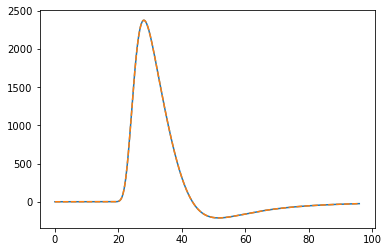

In [18]:
# Plot function
x_py = x_cpp.copy()
y_py = py_landau_fit(x_py, *fit_params)
plt.plot(x_cpp, y_cpp)
plt.plot(x_py, y_py, '--')


def py_landau_fit_negative(x, *p):
    return -1 * py_landau_fit(x, *p)[0]

print("XMaximum = ", brent(py_landau_fit_negative, tuple(fit_params), (25, 30)))

## Step 4: Fit with Python function and iminuit

In [21]:
def fit_function(scale0, mpv0, sigma0, scale1, mpv1, sigma1):
    y_fit = py_landau_fit(x_wf, scale0, mpv0, sigma0, scale1, mpv1, sigma1)
    error = 1
    chi2 = np.sum((y_wf - y_fit / error) ** 2)
    return chi2

def python_fit():
    # Default fit parameter settings
    PEAKPOS = 30

    initial = {
        "scale0": 0, 
        "mpv0": 0, 
        "sigma0": 0, 
        "scale1": 0,
        "mpv1": 0, 
        "sigma1": 0
    }
    if ((initial["scale0"] < 1e-6) & (vped > 0.0)):
        initial = {
            "scale0": vped*11.0, 
            "mpv0": PEAKPOS, 
            "sigma0": 3.0, 
            "scale1": vped*(-2.75),
            "mpv1": PEAKPOS+21, 
            "sigma1": 6.5
        }
    elif ((initial["scale0"] > -1e-6) & (vped < 0.0)):
        initial = {
            "scale0": vped*4.0, 
            "mpv0": PEAKPOS, 
            "sigma0": 3.0, 
            "scale1": vped*(-1.5),
            "mpv1": PEAKPOS+34, 
            "sigma1": 6.5
        }
    stepsize = {f"error_{key}": value*0.3 for key, value in initial.items()}

    m0 = iminuit.Minuit(fit_function, **initial, **stepsize, print_level=0, pedantic=False, throw_nan=True)
    m0.migrad()
    return m0.values

coeff = python_fit()

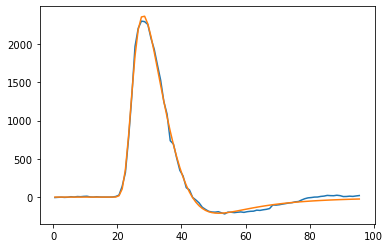

In [22]:
plt.plot(x_wf, y_wf)
plt.plot(x_wf, py_landau_fit(x_wf, **coeff))

## Step 5: Optimisations

In [23]:
%timeit root_fit()
%timeit python_fit()

2.5 ms ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
334 ms ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Currently the Python fit is a factor of >100 times slower than the ROOT fitting. Lets speed up the Python algorithm with numba.

**!!WARNING, restart of kernel is required (numba incompatibility with ROOT interpreter**

In [ ]:
# Restart Kernel so we can import numba
import os
os._exit(00)

In [2]:
import numpy as np
from scipy.optimize import brent
from scipy.stats.distributions import poisson
import iminuit
from matplotlib import pyplot as plt
from numba import njit, vectorize, float64, float32
%matplotlib inline

In [3]:
# Load dataset
wf = np.loadtxt("test_wf.txt")
vped = 800
    
x_wf = np.linspace(0.5, 95.5, wf.size)
y_wf = wf.astype(np.int)

In [9]:
p1 = np.array([0.4259894875,-0.1249762550, 0.03984243700, -0.006298287635,   0.001511162253])
q1 = np.array([1.0         ,-0.3388260629, 0.09594393323, -0.01608042283,    0.003778942063])
p2 = np.array([0.1788541609, 0.1173957403, 0.01488850518, -0.001394989411,   0.0001283617211])
q2 = np.array([1.0         , 0.7428795082, 0.3153932961,   0.06694219548,    0.008790609714])
p3 = np.array([0.1788544503, 0.09359161662,0.006325387654, 0.00006611667319,-0.000002031049101])
q3 = np.array([1.0         , 0.6097809921, 0.2560616665,   0.04746722384,    0.006957301675])
p4 = np.array([0.9874054407, 118.6723273,  849.2794360,   -743.7792444,      427.0262186])
q4 = np.array([1.0         , 106.8615961,  337.6496214,    2016.712389,      1597.063511])
p5 = np.array([1.003675074,  167.5702434,  4789.711289,    21217.86767,     -22324.94910])
q5 = np.array([1.0         , 156.9424537,  3745.310488,    9834.698876,      66924.28357])
p6 = np.array([1.000827619,  664.9143136,  62972.92665,    475554.6998,     -5743609.109])
q6 = np.array([1.0         , 651.4101098,  56974.73333,    165917.4725,     -2815759.939])
a1 = np.array([0.04166666667,-0.01996527778, 0.02709538966])
a2 = np.array([-1.845568670,-4.284640743])

@vectorize([float64(float64, float64, float64)], fastmath=True)
def nb_landau_pdf(x, xi=1, x0=0):
    if (xi <= 0):
        return 0
    v = (x - x0)/xi
    if (v < -5.5):
        u   = np.exp(v+1.0)
        if (u < 1e-10): 
            return 0.0
        ue  = np.exp(-1/u)
        us  = np.sqrt(u)
        denlan = 0.3989422803*(ue/us)*(1+(a1[0]+(a1[1]+a1[2]*u)*u)*u)
    elif (v < -1):
        u   = np.exp(-v-1);
        denlan = np.exp(-u)*np.sqrt(u)*(p1[0]+(p1[1]+(p1[2]+(p1[3]+p1[4]*v)*v)*v)*v)/(q1[0]+(q1[1]+(q1[2]+(q1[3]+q1[4]*v)*v)*v)*v)
    elif (v < 1):
        denlan = (p2[0]+(p2[1]+(p2[2]+(p2[3]+p2[4]*v)*v)*v)*v)/(q2[0]+(q2[1]+(q2[2]+(q2[3]+q2[4]*v)*v)*v)*v)
    elif (v < 5):
        denlan = (p3[0]+(p3[1]+(p3[2]+(p3[3]+p3[4]*v)*v)*v)*v)/(q3[0]+(q3[1]+(q3[2]+(q3[3]+q3[4]*v)*v)*v)*v)
    elif (v < 12):
        u   = 1/v
        denlan = u*u*(p4[0]+(p4[1]+(p4[2]+(p4[3]+p4[4]*u)*u)*u)*u)/(q4[0]+(q4[1]+(q4[2]+(q4[3]+q4[4]*u)*u)*u)*u)
    elif (v < 50):
        u = 1/v
        denlan = u*u*(p5[0]+(p5[1]+(p5[2]+(p5[3]+p5[4]*u)*u)*u)*u)/(q5[0]+(q5[1]+(q5[2]+(q5[3]+q5[4]*u)*u)*u)*u)
    elif (v < 300):
        u   = 1/v
        denlan = u*u*(p6[0]+(p6[1]+(p6[2]+(p6[3]+p6[4]*u)*u)*u)*u)/(q6[0]+(q6[1]+(q6[2]+(q6[3]+q6[4]*u)*u)*u)*u)
    else:
        u   = 1/(v-v*np.log(v)/(v+1))
        denlan = u*u*(1+(a2[0]+a2[1]*u)*u)
    return denlan/xi;

@vectorize([float64(float64, float64, float64)], fastmath=True)
def nb_landau(x, mpv, sigma):
    if (sigma <= 0):
        return 0
    return nb_landau_pdf( (x-mpv)/sigma, 1, 0)

@vectorize([float64(float64, float64, float64, float64, float64, float64, float64)], fastmath=True)
def nb_landau_fit(x, scale0, mpv0, sigma0, scale1, mpv1, sigma1):
    return scale0 * nb_landau(x, mpv0, sigma0) + scale1 * nb_landau(x, mpv1, sigma1)

In [10]:
@njit
def fit_function(scale0, mpv0, sigma0, scale1, mpv1, sigma1):
    y_fit = nb_landau_fit(x_wf, scale0, mpv0, sigma0, scale1, mpv1, sigma1)
    error = 1
    chi2 = np.sum((y_wf - y_fit / error) ** 2)
    return chi2

def nb_fit():
    # Default fit parameter settings
    PEAKPOS = 30

    initial = {
        "scale0": 0, 
        "mpv0": 0, 
        "sigma0": 0, 
        "scale1": 0,
        "mpv1": 0, 
        "sigma1": 0
    }
    if ((initial["scale0"] < 1e-6) & (vped > 0.0)):
        initial = {
            "scale0": vped*11.0, 
            "mpv0": PEAKPOS, 
            "sigma0": 3.0, 
            "scale1": vped*(-2.75),
            "mpv1": PEAKPOS+21, 
            "sigma1": 6.5
        }
    elif ((initial["scale0"] > -1e-6) & (vped < 0.0)):
        initial = {
            "scale0": vped*4.0, 
            "mpv0": PEAKPOS, 
            "sigma0": 3.0, 
            "scale1": vped*(-1.5),
            "mpv1": PEAKPOS+34, 
            "sigma1": 6.5
        }
    stepsize = {f"error_{key}": value*0.3 for key, value in initial.items()}

    m0 = iminuit.Minuit(fit_function, **initial, **stepsize, print_level=0, pedantic=False, throw_nan=True)
    m0.migrad()
    return m0.values

coeff = nb_fit()

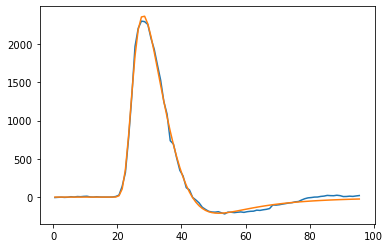

In [11]:
plt.plot(x_wf, y_wf)
plt.plot(x_wf, nb_landau_fit(x_wf, *coeff.values()))

In [12]:
%timeit nb_fit()

1.15 ms ± 92.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Back on par with the ROOT fitting algorithm! (and a factor of 2 speed up!)